In [111]:
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from pymongo import MongoClient

%matplotlib inline

# connecting to mongodb

In [3]:
client = MongoClient('localhost:27017')
db = client.arXivDB
db.arXivfeeds.count()

46898

retrieving the available fields as a reference

In [13]:
print(db.arXivfeeds.find_one().keys())

dict_keys(['arxiv_primary_category', 'updated', 'link', 'arxiv_doi', 'author', 'author_detail', 'published_parsed', 'id', 'authors', '_id', 'summary_detail', 'title_detail', 'arxiv_journal_ref', 'published', 'updated_parsed', 'guidislink', 'arxiv_comment', 'links', 'summary', 'tags', 'title'])


In [58]:
for item in db.arXivfeeds.find({'published_parsed': 2016}).sort('_id', pymongo.DESCENDING).limit(5):
    print(item['title'])

Contextuality under weak assumptions
Phase sensing beyond the standard quantum limit with a truncated SU(1,1)
  interferometer
Highly indistinguishable and strongly entangled photons from symmetric
  GaAs quantum dots
Finite-key-size effect in commercial plug-and-play QKD system
The role of phases in detecting three qubit entanglement


In [44]:
#db.arXivfeeds.delete_many({})

## plotting the wordcloud for abstracts and titles from various years

In [104]:
def plot_abstract_and_title_wordcloud(arXivfeed_query_result):
    
    arXivfeed_2015_text = ' '.join([' '.join(list(d.values())) for d in arXivfeed_query_result])

    # Generate a word cloud image
    wordcloud_arXivfeed_2015 = WordCloud().generate(arXivfeed_2015_text)

    # Display the generated image:
    plt.imshow(wordcloud_arXivfeed_2015)
    plt.axis("off")

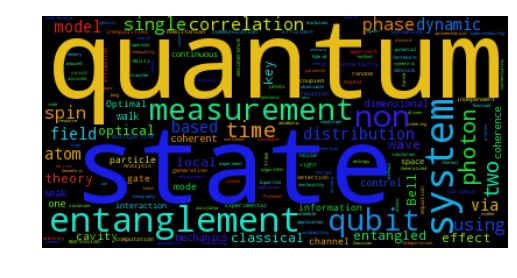

In [105]:
plot_abstract_and_title_wordcloud(list(db.arXivfeeds.find({'published_parsed': 2015}, {'_id':0,'title':1})))

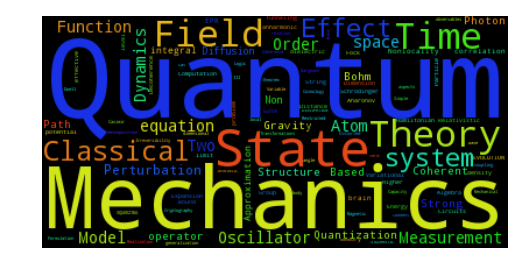

In [106]:
plot_abstract_and_title_wordcloud(list(db.arXivfeeds.find({'published_parsed': 1995}, {'_id':0,'title':1})))

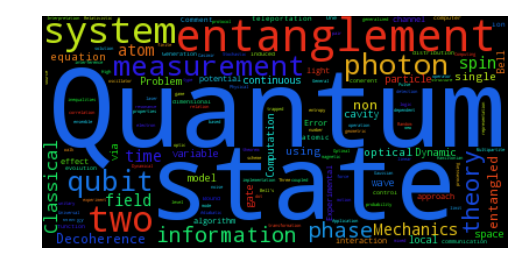

In [107]:
plot_abstract_and_title_wordcloud(list(db.arXivfeeds.find({'published_parsed': 2002}, {'_id':0,'title':1})))

## plotting the number publications per year

In [117]:
num_publications_per_year = [db.arXivfeeds.find({'published_parsed': y}).count() for y in range(1994,2016,1)]

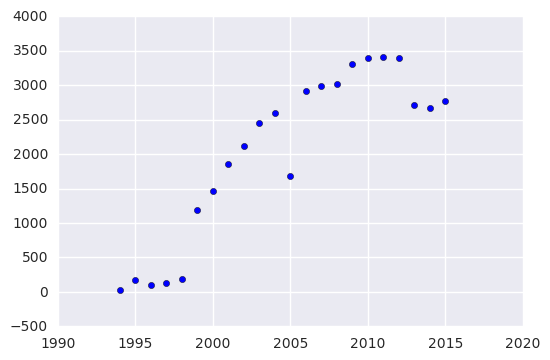

In [118]:
plt.scatter(range(1994,2016,1), num_publications_per_year)

## plotting the world map of author affiliations

## using RNN to create a fake abstract

## using LDA to map out the topics